<a href="https://colab.research.google.com/github/owoshch/Cracking_the_coding_interview_5/blob/master/generative-ysda/seminars/seminar1/PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/r-isachenko/2024-DGM-MIPT-YSDA-course/blob/main/seminars/seminar1/PixelCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.optim as optim
import torch.nn as nn
import torch.utils.data as Tdata
import torch.nn.functional as F
import torch.distributions as TD

from tqdm.notebook import tqdm

if torch.cuda.is_available():
    DEVICE = 'cuda'
    # GPU_DEVICE = 2
    # torch.cuda.set_device(GPU_DEVICE)
else:
    DEVICE='cpu'

import warnings
warnings.filterwarnings('ignore')

# typing
from typing import List, Tuple

## dgm_utils

1. data
2. model
3. train
4. visualize

## Problem setup

In [2]:
# colab dgm_utils install
COMMIT_HASH = "9c3ef18c821268297f31d45e36c3b0f2bb538a80"
!if [ -d dgm_utils ]; then rm -Rf dgm_utils; fi
!git clone https://github.com/r-isachenko/dgm_utils.git
%cd dgm_utils
!git checkout {COMMIT_HASH}
!pip install ./
%cd ./..
!rm -Rf dgm_utils

Cloning into 'dgm_utils'...
remote: Enumerating objects: 138, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (95/95), done.
remote: Total 138 (delta 86), reused 86 (delta 43), pack-reused 0 (from 0)
Receiving objects: 100% (138/138), 27.57 KiB | 6.89 MiB/s, done.
Resolving deltas: 100% (86/86), done.
/content/dgm_utils
Note: switching to '9c3ef18c821268297f31d45e36c3b0f2bb538a80'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 9c3ef18 Return compatibility with Python 3.

In [2]:
from dgm_utils import plot_training_curves
from dgm_utils import show_samples, visualize_images, load_dataset

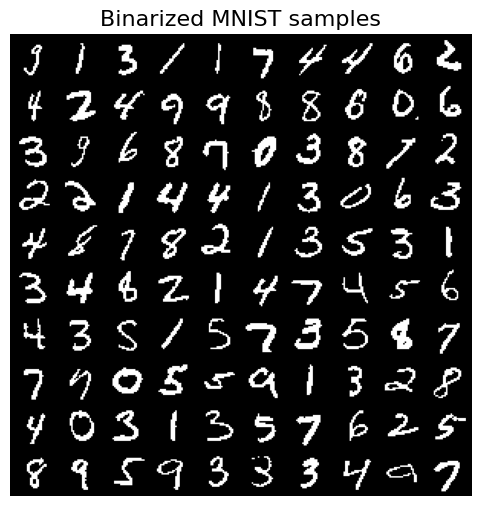

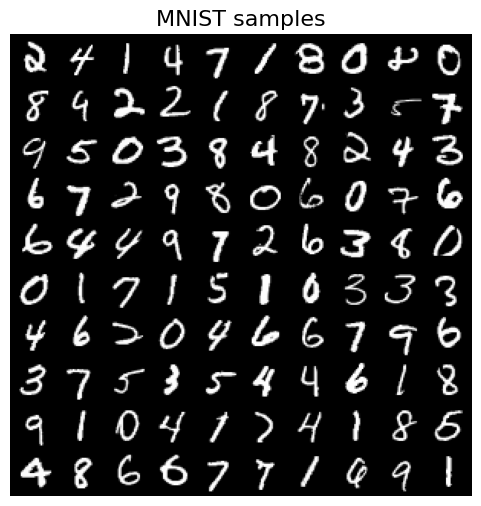

In [3]:
train_data_bin, test_data_bin = load_dataset("mnist", flatten=False, binarize=True)
visualize_images(train_data_bin, "Binarized MNIST samples")
train_data, test_data = load_dataset("mnist", flatten=False, binarize=False)
visualize_images(train_data, "MNIST samples")

## Pixel CNN

The original article: [2016, Oord et. al.](https://arxiv.org/pdf/1601.06759.pdf)

PixelCNN++: [2017, Salimans et. al.](https://arxiv.org/pdf/1701.05517.pdf)

### Autoregressive models for grayscale images

Let $\boldsymbol{x} \sim p(\boldsymbol{x} | \theta) \, , \, \boldsymbol{x} \in \mathbf{R}^{n \times n}$

**Likelihood factorization**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^{n \times n} \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$

**Sampling procedure**:

* Sample $\hat{x}_1 \sim p(x_1 | \theta)$

* Sample $\hat{x}_2 \sim p(x_2 | \hat{x}_1 \theta)$

* ...

* Sample $\hat{x}_{n^2} \sim p(x_{n^2} | \hat{\boldsymbol{x}}_{1:n^2-1} , \theta)$

### Ordering

<center>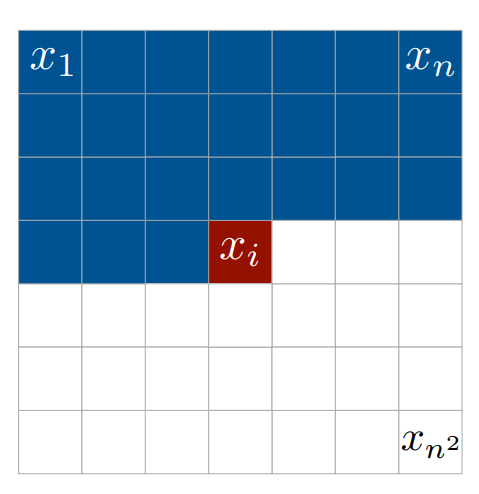</center>

**Question** Will anything change in terms of mathematical formulas for an arbitrary pixel numbering order?

$p(\textbf{x}) = p(x_1)p(x_2|x_1)p(x_3|x_2, x_1)...p(x_N|x_1, ..., x_{N-1})$

## Take a deep breath and work on this step by step

---

## **Masking** to get autoregressive model

### Masked convolutions

* Masked convolution of **type A**:

<center>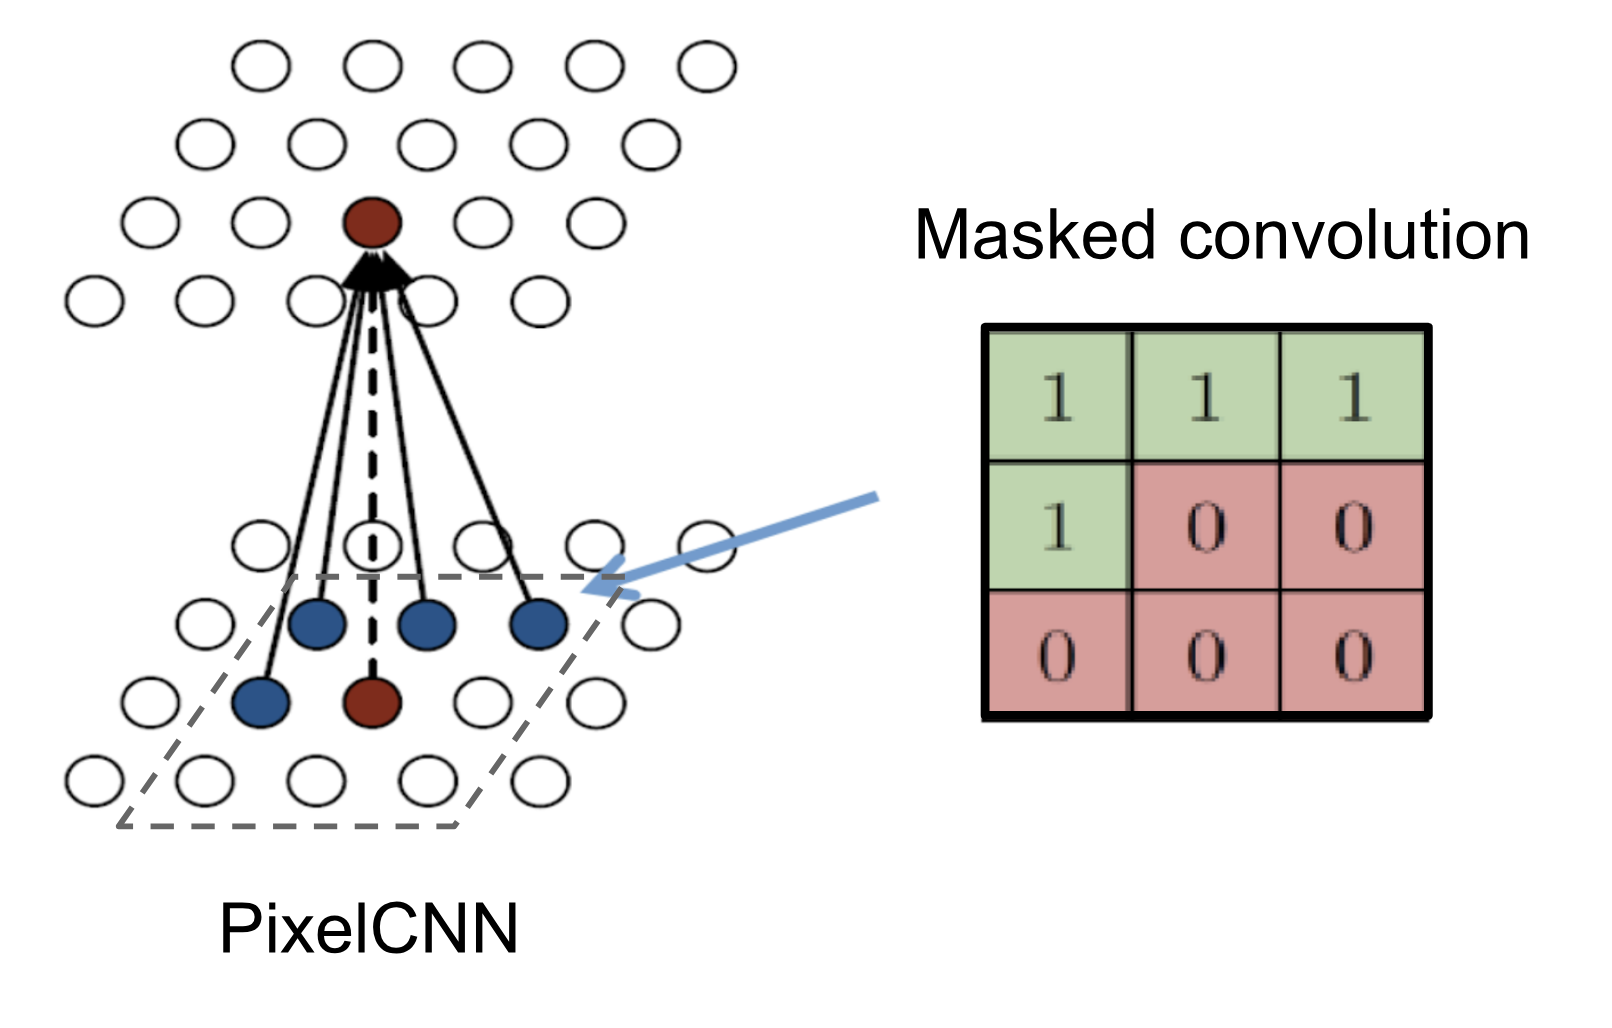</center>

* Masked convolution of **type B** allows self-conditioning

<center>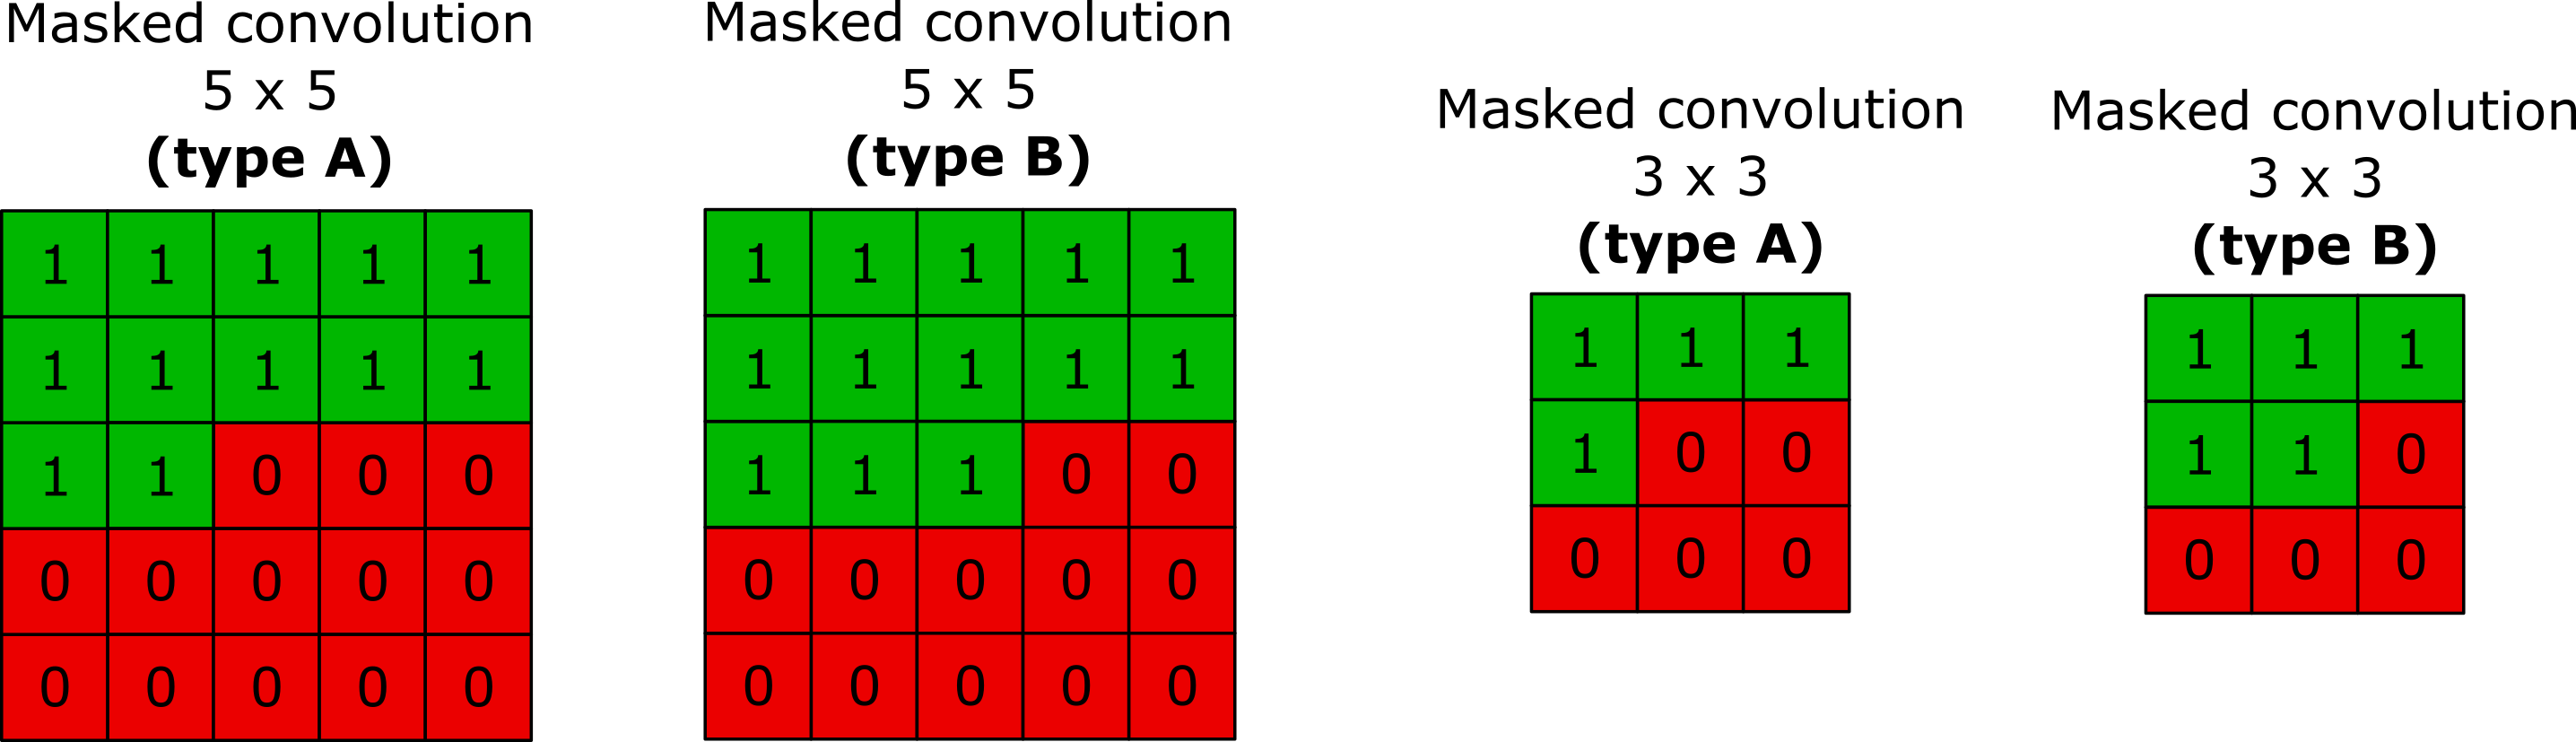</center>

#### Masked convolution implementation

**Question** Why do we need `register_buffer` function? What is the difference between `register_buffer` and `register_parameter`?

In [4]:
class MaskedConv2d(nn.Conv2d):
    def __init__(
        self,
        mask_type: str,
        in_channels: int,
        out_channels: int,
        kernel_size: int = 5
    ) -> None:
        assert mask_type in ["A", "B"]
        super().__init__(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
        )
        self.register_buffer("mask", torch.zeros_like(self.weight))
        self.create_mask(mask_type)

    def forward(
        self,
        input: torch.Tensor
    ) -> torch.Tensor:
        # ====
        # your code
        return F.conv2d(input, self.weight * self.mask, self.bias, padding=self.padding)
        # ====

    def create_mask(
        self,
        mask_type: str
    ) -> None:
        # ====
        # your code
        # do not forget about mask_type
        k = self.kernel_size[0]
        self.mask[:, :, : k // 2] = 1
        self.mask[:, :, k // 2, : k // 2] = 1
        if mask_type == "B":
            self.mask[:, :, k // 2, k // 2] = 1
        # ====


def test_masked_conv2d():
    layer = MaskedConv2d("A", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.zeros((2, 2)))

    layer = MaskedConv2d("B", 2, 2)
    assert np.allclose(layer.mask[:, :, 2, 2].numpy(), np.ones((2, 2)))


test_masked_conv2d()

## PixelCNN implementation details

**Question 1.**: Where can we apply convolutions of **type B** to preserve autoregressive property?

**Question 2.**: Input tensor shapes?

**Question 3.**: Output tensor shapes?


%%markdown

# PixelCNN Implementation Details

Ниже собраны развёрнутые ответы на три ключевых вопроса по реализации MaskedConv2d в PixelCNN. Этот фрагмент можно вставить целиком в ячейку Jupyter Notebook с типом “Markdown”.

---

## 1. Где и зачем применять свёртки **Mask-B** (type B)?

- **Первый слой**:  
  Для первого сверточного слоя всегда используем **Mask-A**. Она **строго** блокирует все пиксели правее, ниже и сам центр ядра. Это гарантирует, что при первом проходе никакой нейрон не «увидит» текущий пиксель \((i, j)\) и не нарушит авторегрессию.

- **Все последующие слои** (включая остаточные блоки и финальный линейный слой):  
  Используем **Mask-B**. Эта маска также блокирует пиксели, идущие правее и ниже, но **разрешает** видеть собственный центральный пиксель \((i, j)\).  
  - **Почему «B», а не «A»?**  
    - После первого слоя все признаки уже были вычислены без утечек.  
    - Если бы мы во втором и следующих слоях продолжали блокировать центр (Mask-A), то на каждом уровне пиксель \((i,j)\) **никогда** не получил бы информации о своём собственном значении и «признаков себя» (слепое пятно).  
    - Mask-B позволяет пикселю «услышать» свою собственную активацию дальних слоёв, сохранив при этом строгую causal-структуру (никуда не заглядывая вправо/вниз).

| Слой         | Маска | Видимость центра | Сохранение авторегрессии |
|--------------|-------|------------------|--------------------------|
| Первый слой  | A     | ✗                | ✔                        |
| Скрытые слои | B     | ✔                | ✔                        |
| Выходной     | B     | ✔                | ✔                        |

---

## 2. Какие формы (shapes) тензоров на входе?

- **Стандартный формат** \( \texttt{(N, C, H, W)} \):
  - **N** — размер батча (batch size)  
  - **C** — число каналов (1 для MNIST, 3 для RGB, или \(K\) при one-hot-кодировании градаций)  
  - **H**, **W** — высота и ширина изображения  

- **Примеры**:  
  1. **Бинарный MNIST (0/1)**  
     ```python
     x.shape == (N, 1, 28, 28)
     ```
  2. **One-hot для 2 состояний**  
     ```python
     x.shape == (N, 2, 28, 28)
     ```
  3. **Цветной CIFAR-10 (256 уровней)**  
     ```python
     x.shape == (N, 3*256, 32, 32)
     ```
     — здесь каждый канал одного пикселя развёрнут в 256-мерный one-hot.

---

## 3. Какие формы тензоров на выходе?

- После последнего Mask-B слоя мы получаем **логиты** для каждого пикселя. Выход имеет формат  
  \[
    (N,\, C \times K,\, H,\, W)
  \]
  где  
  - \(C\) — число исходных каналов,  
  - \(K\) — число возможных состояний пикселя (для бинарного \(K=1\) или \(K=2\), для 8-битного градационного \(K=256\)).  

- **Далее**:
  - **Бинарный** (Bernoulli):  
    ```python
    logits.shape == (N, 1, H, W)
    probs = torch.sigmoid(logits)  # вероятность 1
    ```
  - **Категориальный** (Multi-softmax):  
    ```python
    logits.shape == (N, C*256, H, W)
    # Разворачиваем:
    logits = logits.view(N, C, 256, H, W)
    probs  = torch.softmax(logits, dim=2)
    ```
    — `probs[..., k, i, j]` даёт \(P(x_{i,j}=k)\).

---

**Итог**:  
1. **Mask-A** только в первом слое, **Mask-B** во всех остальных — для устранения «слепых пятен» и сохранения authorregressive property.  
2. Вход: `N×C×H×W` (или `N×(C·K)×H×W` при one-hot).  
3. Выход: логиты формы `N×(C·K)×H×W`, которые затем через `sigmoid` или `softmax` превращаются в вероятности.


* **PixelCNN** is fully convolutional NN, which applies masked convolution of **type A** to the input layer and convolutions of **type B** to the hidden layers.

* It preserves spacial dimensions of a processed tensor

**Question.** How to preserve spatial dimensionality of a processed tensor?

**Helpfull trick** [Layer Normalization](https://arxiv.org/abs/1607.06450) (applied to **channel** dimension) helps to stabilize training process.

**Random fact**
https://arxiv.org/pdf/1803.08494.pdf

<img src="https://github.com/r-isachenko/2024-DGM-MIPT-YSDA-course/blob/main/seminars/seminar1/pics/NormLayers.png?raw=1" width=1200 />

In [5]:
class LayerNorm(nn.LayerNorm):
    def __init__(self, n_filters: int) -> None:
        """
        Специализированный LayerNorm для входов формы (N, C, H, W),
        где C == n_filters — число каналов.
        """
        # Инициализируем базовый nn.LayerNorm, где нормализация идёт по последнему измерению
        super().__init__(n_filters)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Применяем LayerNorm к тензору формы (N, C, H, W).
        Встроенный nn.LayerNorm ожидает, что признаки находятся в последнем измерении,
        поэтому временно меняем порядок осей.
        """
        # x: (N, C, H, W)
        # Меняем оси так, чтобы каналы C оказались в последнем измерении:
        # → (N, H, W, C)
        x = x.permute(0, 2, 3, 1).contiguous()

        # Применяем стандартную нормализацию по последнему измерению (C)
        # В базовом nn.LayerNorm настроено изучать γ и β для каждой из C компонент
        x = super().forward(x)

        # Возвращаем тензор в исходный формат (N, C, H, W)
        # Меняем оси обратно: (N, H, W, C) → (N, C, H, W)
        x = x.permute(0, 3, 1, 2).contiguous()

        return x

## Generic PixelCNN model

In [6]:
class PixelCNNGeneric(nn.Module):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__()
        self.spat_shape = spat_shape
        self.out_chan = out_chan

        # ====
        # your code
        # apply the sequence of MaskedConv2d -> LayerNorm (it is optional) -> ReLU
        # the last layer should be MaskedConv2d (not ReLU) Question: Why?
        # Note 1: the first conv layer should be of type 'A'
        # Note 2: final output_dim in MaskedConv2d must be out_chan
        model = [MaskedConv2d("A", 1, hid_chans[0], kernel_size=kernel_size)]

        for in_hid_chan, out_hid_chan in zip(hid_chans[:-1], hid_chans[1:]):
            if use_layer_norm:
                model.append(LayerNorm(in_hid_chan))
            model.append(nn.ReLU())
            model.append(
                MaskedConv2d("B", in_hid_chan, out_hid_chan, kernel_size=kernel_size)
            )

        model.extend(
            [
                nn.ReLU(),
                MaskedConv2d("B", in_channels=hid_chans[-1], out_channels=out_chan, kernel_size=1),
            ]
        )

        self.net = nn.Sequential(*model)
        # ====

    def forward(
        self, x: torch.Tensor
    ) -> torch.Tensor:
        batch_size = x.shape[0]
        out = (x.float() - 0.5) / 0.5 # Why?
        out = self.net(out)
        # =====
        # your code
        return out.view(batch_size, self.out_chan, 1, *self.spat_shape)
        # =====

### PixelCNN optimization and sampling

**Question 1.** What is the loss function for

* BinarizedMNIST problem?

* Original (grayscale) MNIST problem?

**Question 2.** How to sample from PixelCNN?

#### PixelCNN based on CrossEntropy. Implementation

In [7]:
import itertools

class CrossEntropyPixelCNNGeneric(PixelCNNGeneric):

    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        out_chan: int = 2,
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        assert out_chan >= 2

        super().__init__(
            spat_shape,
            hid_chans=hid_chans,
            out_chan=out_chan,
            kernel_size=kernel_size,
            use_layer_norm=use_layer_norm)

        #Note! Will average the output (i.e., returns scaled log likelihood)
        # =======
        # your code
        self.loss_fn = nn.CrossEntropyLoss()
        # ======

    def sample(
        self, n: int
    ) -> np.ndarray:
        # =====
        # your code
        # Note 1: Use torch.multinomial
        # Note 2: Output values should be in [0,1]
        samples = torch.zeros(n, 1, *self.spat_shape).to(DEVICE)
        ordering = itertools.product(range(self.spat_shape[0]), range(self.spat_shape[1]))
        with torch.no_grad():
            for (r, c) in ordering:
                logits = self(samples)[..., r, c] # (bs, out_chan=K, 1)
                probs = F.softmax(logits.squeeze(-1), dim=1) # (bs, out_chan)
                samples[..., r, c] = torch.multinomial(probs, num_samples=1) / float(self.out_chan - 1) # grayscale [0,1]
        # =====
        return samples.cpu().numpy()

####  PixelCNN for binarized MNIST

In [8]:
class BinarizedPixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 64, 64, 64, 64],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape,
            hid_chans=hid_chans,
            out_chan=2,
            kernel_size=kernel_size,
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        total_loss = self.loss_fn(self(x), x.long())
        # ====
        return {"total_loss": total_loss}

#### PixelCNN for grayscaled MNIST

In [9]:
class GrayScalePixelCNN(CrossEntropyPixelCNNGeneric):
    def __init__(
        self,
        spat_shape: Tuple[int],
        hid_chans: List[int] = [64, 128, 256, 512, 256],
        kernel_size: int = 7,
        use_layer_norm: bool = True,
    ) -> None:

        super().__init__(
            spat_shape,
            hid_chans=hid_chans,
            out_chan=256,
            kernel_size=kernel_size,
            use_layer_norm=use_layer_norm)

    def loss(self, x: torch.Tensor) -> dict:
        # ====
        # your code
        # Note: x in [0, 1]
        total_loss = self.loss_fn(self(x), (x * 255.).long())
        # ====
        return {"total_loss": total_loss}

### Training PixelCNN for Binarize MNIST

In [10]:
from dgm_utils import train_model
from torch.optim import Adam

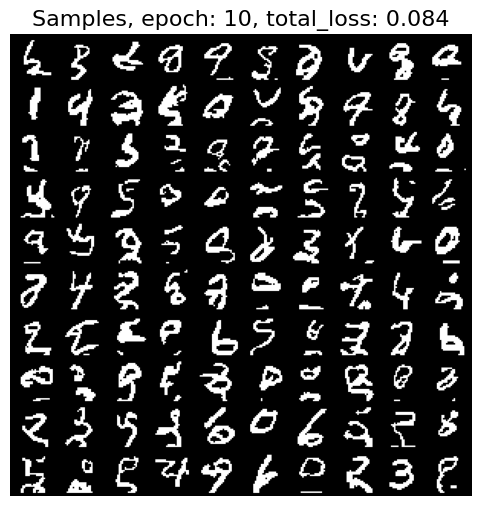

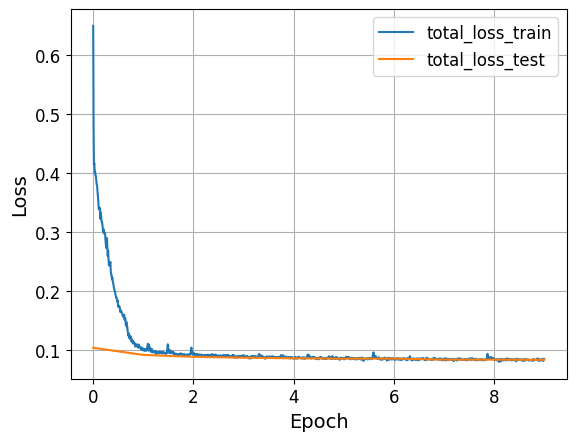

End of the training


In [11]:
# ====
# set your params
EPOCHS = 10  # > 5
BATCH_SIZE = 512  # any adequate value
LR = 1e-3  # < 1e-2
N_LAYERS = 5  # < 10
N_FILTERS = 128  # < 128
USE_LAYER_NORM = True
# ====

model = BinarizedPixelCNN(
    spat_shape=(28, 28),
    hid_chans = [N_FILTERS,] * N_LAYERS,
    kernel_size=5,
    use_layer_norm=USE_LAYER_NORM,
).to(DEVICE)

train_loader = Tdata.DataLoader(train_data_bin, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Tdata.DataLoader(test_data_bin, batch_size=BATCH_SIZE)

optimizer = Adam(model.parameters(), lr=LR)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=None,  # No scheduler for a constant learning rate
    device=DEVICE,
    loss_key="total_loss",  # Use the default loss key or specify as needed
    n_samples=100,  # Set number of samples for visualization
    visualize_samples=True  # Set to False if you don't want visualization
)

In [13]:
plot_training_curves(train_losses, test_losses)

NameError: name 'train_losses' is not defined

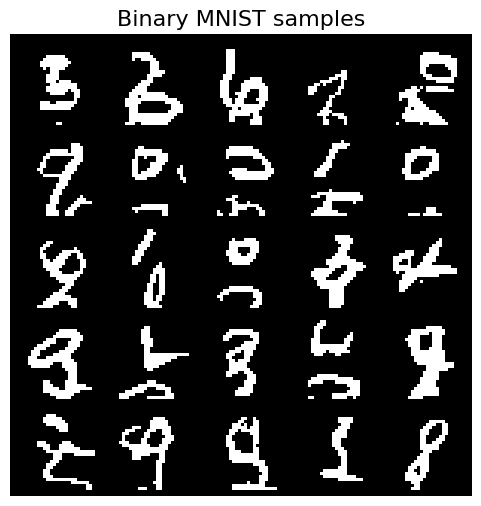

In [14]:
samples = model.sample(25)
show_samples(samples, title="Binary MNIST samples", nrow=5)

#### Training PixelCNN for grayscaled MNIST

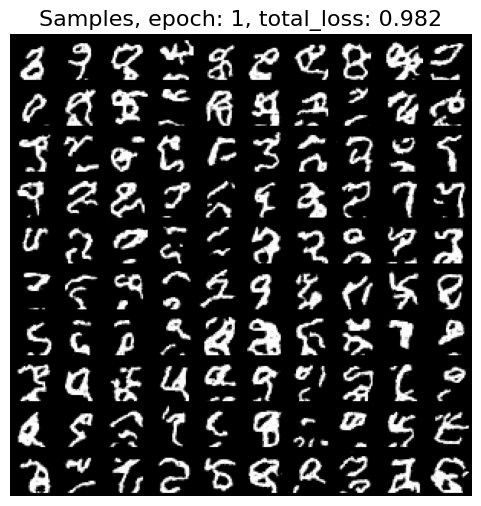

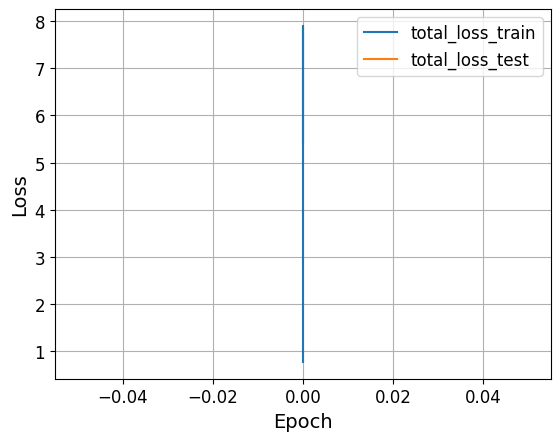

Training epoch 2:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
# ====
# set your params
EPOCHS = 10  # > 5
BATCH_SIZE = 128  # any adequate value
LR = 5e-3  # < 1e-2
HIDDEN_CHANNELS = [64, 128, 256, 256, 256]
USE_LAYER_NORM = True
# ====

model = GrayScalePixelCNN(
    spat_shape=(28, 28),
    hid_chans = HIDDEN_CHANNELS,
    kernel_size=5,
    use_layer_norm=USE_LAYER_NORM,
).to(DEVICE)

train_loader = Tdata.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = Tdata.DataLoader(test_data, batch_size=BATCH_SIZE)

optimizer = Adam(model.parameters(), lr=LR)

train_model(
    model=model,
    train_loader=train_loader,
    test_loader=test_loader,
    epochs=EPOCHS,
    optimizer=optimizer,
    scheduler=None,  # No scheduler for a constant learning rate
    device=DEVICE,
    loss_key="total_loss",  # Use the default loss key or specify as needed
    n_samples=100,  # Set number of samples for visualization
    visualize_samples=True  # Set to False if you don't want visualization
)

In [ ]:
plot_training_curves(train_losses, test_losses)

In [ ]:
samples = model.sample(25)
show_samples(samples, title="MNIST samples", nrow=5)

### PixelCNN for RGB images

$p\left(x_i | \boldsymbol{x}_{1:i-1}, \theta \right) = p\left(x_{i, R} | \boldsymbol{x}_{1:i-1}, \theta \right) p\left(x_{i, G} | x_{i, R}, \boldsymbol{x}_{1:i-1}, \theta\right) p\left(x_{i, B} | x_{i, R}, x_{i, G}, \boldsymbol{x}_{1:i-1}, \theta\right)$

<center>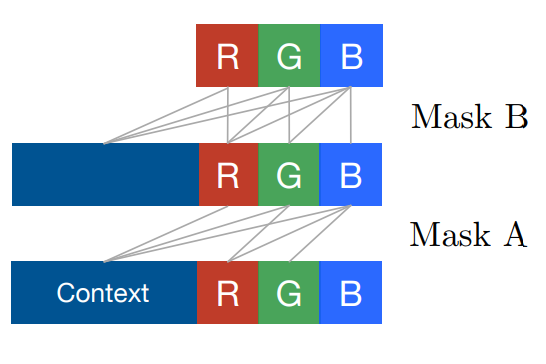</center>

**Question 1.** Input and output tensor shapes? Loss function?

**Question 2.** How to preserve `RGB` structure through the convolutions? How do convolutions look like?

## Futher steps

**Question.** Can PixelCNN predict something except probabilities of pixel's categorical distribution?

Consider more general classes of distributions ($p(x_j | \boldsymbol{x}_{1:j-1} , \theta) \sim \text{Mixture of Gaussians}$ or $\text{Mixture of Logistics}$).  

For example, `PixelCNN++` [link](https://arxiv.org/pdf/1701.05517.pdf) utilizes mixture of logistics.

## Recap

1. **Input:** image `(batch_size, n_channels , H, W)`\
**Output**: $\log p(\boldsymbol{x} | \theta) = \sum\limits_{j = 1}^{n \times n} \log p\left( x_i | \boldsymbol{x}_{1:j-1} , \theta\right)$  `(batch_size, K_classes, n_channels, H, W)`
2. **Inference**: input image $x_{i:1}$ - probability distribution $p(x_{i+1}|x_{i:1}, \theta)$ - sampling - new image $x_{i+1:1}$
3. **Trainig** using CrossEntropyLoss to maximize Likelihood
4. **Masking** to get autoregressive model